# Project 3B (MENG 35500) - Rebecca D'Antonio

## Monte Carlo II

### 1) Imports

In [1]:
#imports
import os
import math
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits as tk
from numba import jit
from IPython import display

In [2]:
#magic commands
%load_ext autoreload
%autoreload 2

#inline plotting
%matplotlib inline

In [3]:
#fix numpy's random number generator seed
np.random.seed(17896)

### 2) Wrap to Periodic Boundary Conditions

In [4]:
#apply periodic boundary conditions of LxLxL cubic box to particle
#whose (x,y,z) coordinates are held in 3-element vector r
def wrap(r, L): 
    
    #r[0]=x, r[1]=y, r[2]=z
    
    #if x < l, x = x+L
    if (r[0] < L): 
        r[0] = r[0] + L
    #if x > L, x = x-L
    if (r[0] > L): 
        r[0] = r[0] - L
    #if x = L, map back to 0
    if (r[0] == L):
        r[0] = 0
        
        
    #if y < l, y = y+L
    if (r[1] < L): 
        r[1] = r[1] + L
    #if y > L, y = y-L
    if (r[1] > L): 
        r[1] = r[1] - L
    #if y = L, map back to 0
    if (r[1] == L):
        r[1] = 0
        
    #if z < l, z = z+L
    if (r[2] < L): 
        r[2] = r[2] + L
    #if z > L, z = z-L
    if (r[2] > L): 
        r[2] = r[2] - L
    #if z = L, map back to 0
    if (r[2] == L):
        r[2] = 0
    
    return r

### 3) Minimum Image Distance

In [5]:
#compute minimum image distance between 2 atoms whose (x,y,z) 
#coordinates are held in 3-element vectors r1 and r2
def dist(r1, r2, L): 
    
    #first wrap both atoms to make sure inside box
    r1 = wrap(r1, L)
    r2 = wrap(r2, L)
    
    #define dx, dy, and dz as the absolute values of the differences 
    #in each coordinate direction per vector
    dx = abs(r1[0] - r2[0])
    dy = abs(r1[1] - r2[1])
    dz = abs(r1[2] - r2[2])
    
    #if any of the distances (in x,y,z direction) are greater than half the
    #length of the box, the minimum image distance should be re defined as 
    # L - the original separation
    if (dx > L/2): 
        dx = L - dx
    if (dy > L/2): 
        dy = L - dy
    if (dz > L/2): 
        dz = L - dz
    
    #distance equation (magnitude)
    d = math.sqrt((dx)**2+(dy)**2+(dz)**2)
    
    return d  

### 4) Pairwise Energy

In [6]:
#compute energy between 2 particles i and j separated by a distance
#s according to the Lennard-Jones potential
def E_ij(s, sigma, epsilon):
    
    #lennard jones formula for energy
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return 4*epsilon*(q12-q6)

### 5) Pairwise Force

In [7]:
#compute the force on particle i exerterd by particle j under Lennard-Jones
#potential, wheere r = r_ij = r_j - r_i
def f_ij(r, sigma, epsilon):
    
    s = math.sqrt(r[0]**2+r[1]**2+r[2]**2)
    
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return -(48*epsilon/s**2)*(q12 - 0.5*q6)*r

### 6) Initialization - random

In [8]:
#randomly position the N Ar atoms within the cubic box of side length L
#avoiding collisions between particles at distances closer than sigma
def init_rand(N, L, sigma):
    
    #initialize xyz as N x 3 matrix
    xyz = np.zeros((N, 3))
    
    for i in range(0,N): 
        
        #create a test array for positions, only accept the position at i if not within sigma of any other positions
        pos = np.zeros((N, 3))
        pos[i] = np.random.random(3)*L
        
        #loop through all positions, only accept the position at i if not within sigma of any other atoms
        count = 0
        while (count < i):
    
            #if within sigma, create new random position
            if (dist(xyz[count], pos[i], L) < sigma):
                
                pos[i] = np.random.random(3)*L
                count = 0 
                
            count+=1
        
        #accept position, add it to xyz
        xyz[i] = pos[i]
       
    return xyz

### 7) Initialization - crystal

In [9]:
#position the N Ar atoms within the cubic box of side length L on a 
#simple cubic crystal lattice
def init_xtal(N, L):
    
    #initialize empty position array that is 3 dimensions (xyz) x the number of atoms
    pos = np.zeros((N, 3))
    
    #take the cubic root of the total number of atoms to find the number in a single dimension
    nPerSide = int(np.ceil(pow(N,(1.0/3.0)))) 
    
    
    #initialize every position of atoms in a 3D box, dependent on the desntiy (length of the side, number of atoms per that length)
    counter = 0 #start at position 0
    for i in range(0,nPerSide): #x
        for j in range(0,nPerSide): #y
            for k in range(0,nPerSide): #z
                if (counter < N):
                    #initialize positions at #(x,y,z)*L/dimension
                    pos[counter, 0] = i*L/nPerSide
                    pos[counter, 1] = j*L/nPerSide
                    pos[counter, 2] = k*L/nPerSide
                    counter += 1 
                    
    return pos

### 8) Total Energy

In [10]:
#compute the total potential energy of a hypothetical particle at location
#r = r(vector) with rest of system of particle held in xyz with exception of
#particle i 
#(aka, return energy of system if particle i moved to new location w/o 
#modifying xyz)
def E_i(r, i, xyz, L, sigma, epsilon):
    
    N = xyz.shape[0]
    
    #initialize E to 0
    E_i = 0
    
    #sum over all pairwise interactions between particle i and rest of atoms (skipping i = j because that refers to same atom)
    for j in range(N):
        if j!=i:
            rj = xyz[j,:]
            d = dist(r,rj,L)
            #then add pairwise energy between i and each particle in system to total
            E_i += E_ij(d,sigma,epsilon)
    
    return E_i

In [11]:
#compute the total potential energy of the system
def E_system(xyz, L, sigma, epsilon):
    
    N = xyz.shape[0]
    
    #initialize system E ot 0
    Esys = 0
    
    #loop through pairwise interactions between ALL atoms
    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            #then add pairwise energy between i and each particle in system to total
            Esys += E_ij(d,sigma,epsilon)
    
    return Esys

### 9) Visualization

In [12]:
#grpahing function to plot system configuration held in xyz
def plot_config(xyz, L):
    
    #plot the 3D representation of xyz
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    #set axes [0, L]
    ax.axes.set_xlim3d(left=0, right=L)  
    ax.axes.set_ylim3d(bottom=0, top=L) 
    ax.axes.set_zlim3d(bottom=0, top=L) 
    #labels
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_zlabel('z (nm)')
    ax.scatter(x, y, z, c=z, alpha=1)

    plt.show()

### 10) Coordinate write

In [13]:
#write current (x,y,z) coordinate triplets of all N atoms in system
#to file in xyz-format
def xyzWrite(xyz, outfile, writestyle):
    
    #either open the file as write or append 
    if (writestyle == 'w'): 
        outFile = open(outfile, 'w')
    if (writestyle == 'a'):
        outFile = open(outfile, 'a')
    
    #write to file in xyz format
    N = xyz.shape[0]
    outFile.write("%d\n" % N)
    outFile.write("\n")
  
    for i in range(0, xyz.shape[0]):
        #nm->angstroms
        outFile.write("Ar %6.2f %6.2f %6.2f\n" % (xyz[i,0]*10, xyz[i,1]*10, xyz[i,2]*10))
     
    outFile.close()               

### 11) Deployment

Illustrate successful deployment:

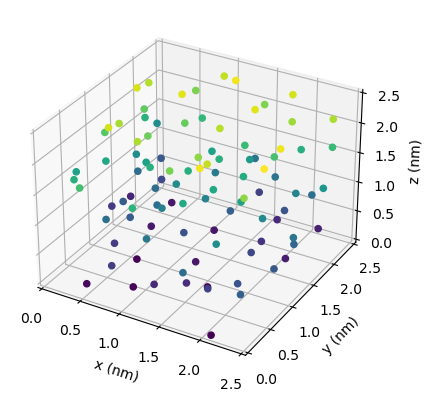

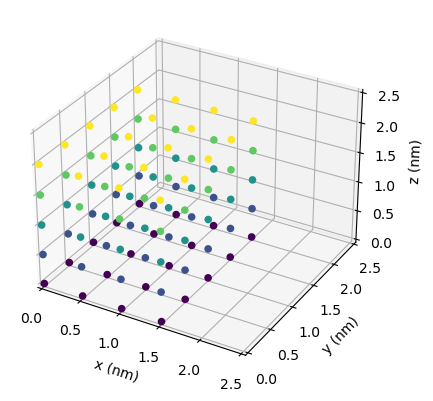

i = 0, j = 1
dij = 0.500000 nm
Eij = -0.588012 zJ
rij (nm):
[0.  0.  0.5]
fij (zJ/nm):
[0.         0.         6.28197961]
[0. 0. 0.]
Ei = -3.930762 zJ
E = -221.494854 zJ


In [14]:
N = 100
L = 2.5 # nm
sigma = 0.34 # nm
epsilon = 1.65 #zJ

xyz = init_rand(N, L, sigma)
plot_config(xyz, L)

xyz = init_xtal(N, L)
plot_config(xyz, L)

i = 0
j = 1
print('i = %d, j = %d' % (i,j))

dij = dist(xyz[i,:],xyz[j,:], L)
print('dij = %f nm' % dij)

Eij = E_ij(dij,sigma,epsilon)
print('Eij = %f zJ' % Eij)

rij = xyz[j,:] - xyz[i,:]
print('rij (nm):')
print(rij)

fij = f_ij(rij,sigma,epsilon)
print('fij (zJ/nm):')
print(fij)

print(xyz[i,:])
Ei = E_i(xyz[i,:],i,xyz,L,sigma,epsilon)
print('Ei = %f zJ' % Ei)

E = E_system(xyz,L,sigma,epsilon)
print('E = %f zJ' % E)

outfile = './ArgonFluid.xyz'
xyzWrite(xyz, outfile, 'w')

### 12) User Input 

In [18]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 200
Number of MC Sweeps: 750
Characteristic Size of Atomic Displacement Trial Moves: 0.1
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.038064852


### 13) Main Metropolis Monte Carlo Loop

In [15]:
def MCMC(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB):
    
    #crystal configuration
    xyz = init_xtal(N, L)
    
    #for writing to outfile
    outfile = './Argon_MonteCarlo.xyz'
    xyzWrite(xyz, outfile, 'a')
    
    #initializations
    E = 0
    num_accept = 0
    num_trials = 0
    
    #for plotting
    E_list = np.zeros(nSweeps)
    Sweeps_list = np.zeros(nSweeps)
    
    #inital system energy
    E = E_system(xyz,L,sigma,epsilon)
    
    for i in range(0, nSweeps):
        for j in range(0, N):
            
            #choose random atom
            atom = np.random.randint(0, N)
      
            #store old coordinates
            xyz_atom_old = xyz[atom,:]
            
            #store old configuration energy
            E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)
            
            #random displacement change according to dispSize
            xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)
            
            #wrap positions
            xyz_atom_new_wrap = wrap(xyz_atom_new,L)
            
            #store new configuration energy
            E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)
            
            #calculte energy change
            deltaE = E_atom_new - E_atom_old
         
            #automatically accept lower energy config
            if deltaE < 0:
                xyz[atom,:] = xyz_atom_new_wrap
                E += deltaE
                num_accept += 1
                
            #apply displacement move acceptance criteria
            else:
                if T>0:
                    if np.random.random() < np.exp(-deltaE/(kB*T)):
                        xyz[atom,:] = xyz_atom_new_wrap
                        E += deltaE
                        num_accept += 1
             
            num_trials += 1
        
        #add values to be able to plot
        E_list[i] = E
        Sweeps_list[i] = i+1
        
        #print every printModulus Sweeps
        if(i % printModulus == 0):
            print("System Energy: %.3f" % E)
            if (num_trials > 0):
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
            print("")
        
        #write every writeModulus Sweeps
        if(i % writeModulus == 0):
            xyzWrite(xyz, outfile, 'a')
            
    plt.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
    plt.ylabel('Energy (zJ)')
    plt.xlabel('Sweep Number')
    plt.legend()
    plt.show()
                  

System Energy: -26.563
Acceptance Ratio: 1.000

System Energy: -58.688
Acceptance Ratio: 0.720

System Energy: -71.854
Acceptance Ratio: 0.649

System Energy: -85.543
Acceptance Ratio: 0.610

System Energy: -108.519
Acceptance Ratio: 0.557

System Energy: -124.247
Acceptance Ratio: 0.515

System Energy: -124.386
Acceptance Ratio: 0.484

System Energy: -133.107
Acceptance Ratio: 0.454

System Energy: -120.352
Acceptance Ratio: 0.442

System Energy: -121.751
Acceptance Ratio: 0.428

System Energy: -130.380
Acceptance Ratio: 0.411

System Energy: -139.303
Acceptance Ratio: 0.396

System Energy: -141.298
Acceptance Ratio: 0.384

System Energy: -150.904
Acceptance Ratio: 0.372

System Energy: -157.724
Acceptance Ratio: 0.363

System Energy: -172.497
Acceptance Ratio: 0.351

System Energy: -162.803
Acceptance Ratio: 0.342

System Energy: -153.119
Acceptance Ratio: 0.337

System Energy: -161.448
Acceptance Ratio: 0.331

System Energy: -166.965
Acceptance Ratio: 0.326

System Energy: -172.733


System Energy: -225.946
Acceptance Ratio: 0.160

System Energy: -226.394
Acceptance Ratio: 0.160

System Energy: -228.614
Acceptance Ratio: 0.159

System Energy: -222.647
Acceptance Ratio: 0.159

System Energy: -222.227
Acceptance Ratio: 0.159

System Energy: -230.619
Acceptance Ratio: 0.159

System Energy: -232.933
Acceptance Ratio: 0.159

System Energy: -233.852
Acceptance Ratio: 0.158

System Energy: -237.264
Acceptance Ratio: 0.158

System Energy: -237.091
Acceptance Ratio: 0.158

System Energy: -237.142
Acceptance Ratio: 0.157

System Energy: -235.143
Acceptance Ratio: 0.157

System Energy: -237.817
Acceptance Ratio: 0.157

System Energy: -236.658
Acceptance Ratio: 0.157

System Energy: -245.680
Acceptance Ratio: 0.156

System Energy: -240.212
Acceptance Ratio: 0.156

System Energy: -239.080
Acceptance Ratio: 0.156

System Energy: -242.089
Acceptance Ratio: 0.156

System Energy: -239.716
Acceptance Ratio: 0.155

System Energy: -227.614
Acceptance Ratio: 0.155

System Energy: -222.

System Energy: -221.639
Acceptance Ratio: 0.139

System Energy: -223.184
Acceptance Ratio: 0.139

System Energy: -237.448
Acceptance Ratio: 0.139

System Energy: -244.787
Acceptance Ratio: 0.139

System Energy: -232.911
Acceptance Ratio: 0.139

System Energy: -233.300
Acceptance Ratio: 0.139

System Energy: -238.769
Acceptance Ratio: 0.139

System Energy: -240.153
Acceptance Ratio: 0.139

System Energy: -244.451
Acceptance Ratio: 0.138

System Energy: -239.218
Acceptance Ratio: 0.138

System Energy: -241.899
Acceptance Ratio: 0.138

System Energy: -244.594
Acceptance Ratio: 0.138

System Energy: -242.259
Acceptance Ratio: 0.138

System Energy: -240.724
Acceptance Ratio: 0.138

System Energy: -229.874
Acceptance Ratio: 0.138

System Energy: -227.764
Acceptance Ratio: 0.138

System Energy: -240.023
Acceptance Ratio: 0.137

System Energy: -241.375
Acceptance Ratio: 0.137

System Energy: -240.381
Acceptance Ratio: 0.137

System Energy: -238.317
Acceptance Ratio: 0.137

System Energy: -228.

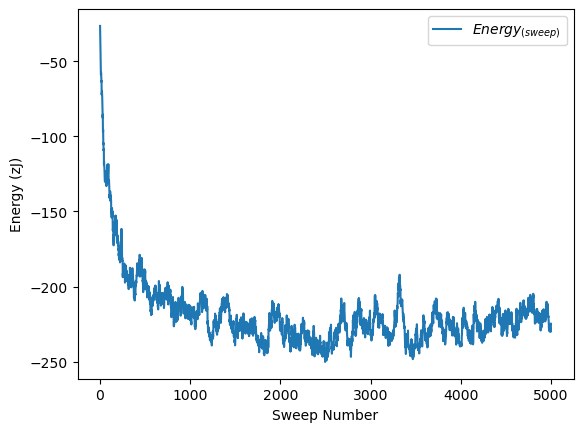

In [265]:
MCMC(50, 2.5, 40, 5000, 0.1, 10, 10, 0.34, 1.65, 1.38064852E-2)

### 14) Equation of State

#### Virial Equation

In [16]:
#compute the vector rj-ri
def rij(i, j, L):
    
    r = np.subtract(j,i)
    r = wrap(r, L)
    
    return r

In [17]:
#compute the pressure in the simulation box using virial equation
def pressure(N, L, T, xyz, sigma, epsilon):
    
    P = 0 #pressure in Pa
    V = L**3 * 1e-27 #volume in m^3
    kB = 1.38064852e-23 #J/K
    rho = N/V #density in 1/m^3
    sigma *= 1e-9 #nm->m
    epsilon *= 1e-21 #zJ -> J
    
    virial = 0
    
    #summation
    for i in range(0, N):
        for j in range(0, i):
            r_ij = rij(xyz[i,:], xyz[j,:], L) #calculate r vector between i and j
            r_ij *=1e-9 #nm->m
            fij = f_ij(r_ij, sigma, epsilon) #calculate pairwise force between i and j 
            virial += np.dot(fij,r_ij) #add the dot product of each pair to total
    virial = virial/(3*V) 
    
    P = (rho*kB*T) - virial #virial equation pressure
    P = P*1e-5 #Pa->bar
    
    return P

#### Pressure Calculation

In [18]:
def MCMC_plot(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB):
    
    xyz = init_rand(N, L, sigma)
    outfile = './ArgonNVT_Pressure.xyz'
    xyzWrite(xyz, outfile, 'a')
    
    #initializations
    E = 0
    P_tot = 0
    P_block_tot = 0
    P_block = np.zeros(5)
    
    #for plotting
    E_list = np.zeros(nSweeps)
    P_list = np.zeros(nSweeps)
    Sweeps_list = np.zeros(nSweeps)
    
    #counters
    num_accept = 0
    num_trials = 0
    blocknum = 0
    
    #inital system energy
    E = E_system(xyz,L,sigma,epsilon)
    
    #MCMC Loop
    for i in range(0, nSweeps):
        for j in range(0, N):
            
            #choose random atom
            atom = np.random.randint(0, N)
      
            #store old coordinates
            xyz_atom_old = xyz[atom,:]
            
            #store old configuration energy
            E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)
            
            #random displacement change according to dispSize
            xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)
            
            #wrap positions
            xyz_atom_new_wrap = wrap(xyz_atom_new,L)
            
            #store new configuration energy
            E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)
            
            #calculte energy change
            deltaE = E_atom_new - E_atom_old
         
            #automatically accept lower energy config
            if deltaE < 0:
                xyz[atom,:] = xyz_atom_new_wrap
                E += deltaE
                num_accept += 1
                
            #apply displacement move acceptance criteria
            else:
                if T>0:
                    if np.random.random() < np.exp(-deltaE/(kB*T)):
                        xyz[atom,:] = xyz_atom_new_wrap
                        E += deltaE
                        num_accept += 1
             
            num_trials += 1
         
        #add values to be able to plot
        E_list[i] = E
        P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
        Sweeps_list[i] = i+1

        #print every printModulus Sweeps
        if(i % printModulus == 0):
            print("System Energy: %.3f" % E)
            print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
            print("")
          
        #write every writeModulus Sweeps
        if(i % writeModulus == 0):
            xyzWrite(xyz, outfile, 'a')
          
        #after first 250 sweeps, conduct block averages
        if(i >= 250):
            P_tot += P_list[i]
            P_block_tot += P_list[i]
            if ((i+250) % 100 == 0 and i != 250):
                P_block[blocknum] = P_block_tot/100
                P_block_tot = 0
                blocknum+=1
    
    #avg P 
    uP = P_tot/500
    
    #avg P per block
    uP_Block = 0
    for i in range (0, blocknum-1): 
        uP_Block += (P_block[i])**2
  
    #standard error
    sigma_P = math.sqrt( abs((uP_Block/(blocknum-1)) - (uP)**2) )
    
    #plots
    fig, (ax1, ax2) = plt.subplots(2,sharex=True)
    
    ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
    ax1.set_ylabel('Energy (zJ)')
    ax1.legend()
    
    ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
    ax2.set_ylabel('Pressure (bar)')
    ax2.legend()
    
    plt.xlabel('Sweep Number')
    plt.show()
    
    #return avg and standard error
    vals = np.zeros(2)
    vals[0] = uP
    vals[1] = sigma_P
    
    return vals
                

N = 200, T = 298 K, L = 2.5nm, nSweeps = 750, $\sigma$ = 0.34nm, $\epsilon$ = 1.65e-21 J

Choose dispSize such that acceptance probability ~ 50%

In [56]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 200
Number of MC Sweeps: 750
Characteristic Size of Atomic Displacement Trial Moves: 0.1
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.0138064852


System Energy: -977.805
Acceptance Ratio: 0.705

System Energy: -1044.565
Acceptance Ratio: 0.656

System Energy: -975.702
Acceptance Ratio: 0.647

System Energy: -961.371
Acceptance Ratio: 0.637

System Energy: -943.059
Acceptance Ratio: 0.633

System Energy: -971.609
Acceptance Ratio: 0.631

System Energy: -983.367
Acceptance Ratio: 0.625

System Energy: -981.516
Acceptance Ratio: 0.626

System Energy: -942.790
Acceptance Ratio: 0.624

System Energy: -937.839
Acceptance Ratio: 0.622

System Energy: -961.286
Acceptance Ratio: 0.621

System Energy: -906.437
Acceptance Ratio: 0.618

System Energy: -953.992
Acceptance Ratio: 0.620

System Energy: -977.420
Acceptance Ratio: 0.622

System Energy: -945.193
Acceptance Ratio: 0.621

System Energy: -979.184
Acceptance Ratio: 0.621

System Energy: -997.341
Acceptance Ratio: 0.620

System Energy: -970.318
Acceptance Ratio: 0.619

System Energy: -1004.485
Acceptance Ratio: 0.618

System Energy: -1028.153
Acceptance Ratio: 0.618

System Energy: -1

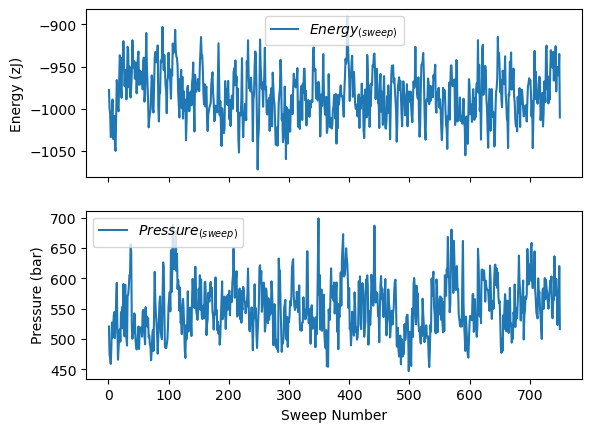

In [53]:
vals = np.zeros(2)
vals = MCMC_plot(298, 2.5, 200, 750, 0.06, 10, 10, 0.34, 1.65, 0.0138064852)

Mean Pressure ($\mu_P$):

In [56]:
uP = vals[0]
print('Mean Pressure = %.2f bar' % uP)

Mean Pressure = 554.15 bar


Standard Error ($\sigma_P$):

In [57]:
sigP = vals[1]
print('Standard Error = %.2f bar' % sigP)

Standard Error = 80.77 bar


#### Pressure-Density Relationship

For acceptance probability ~50%: N = 25, dispSize = 0.5; N = 50, dispSize = 0.4; N = 100, dispSize = 0.15; N = 150, dispSize = 0.075; N = 200, dispSize = 0.06; nSweeps = 750 for all

In [19]:
def MCMC_pres(T, L, N, nSweeps, dispSize, sigma, epsilon, kB):
   
    #return values
    vals = np.zeros(2)
    
    #random configuration
    xyz = init_rand(N, L, sigma)
    
    #initializations
    E = 0
    P_tot = 0
    P_block_tot = 0
    P_block = np.zeros(5)
    uP_list = np.zeros(5)
    
    #for plotting
    E_list = np.zeros(nSweeps)
    P_list = np.zeros(nSweeps)
    Sweeps_list = np.zeros(nSweeps)
    
    #counts
    num_accept = 0
    num_trials = 0
    blocknum = 0
    
    #inital system energy
    E = E_system(xyz,L,sigma,epsilon)
    
    #MCMC Loop
    for i in range(0, nSweeps):
        for j in range(0, N):
            
            #choose random atom
            atom = np.random.randint(0, N)
      
            #store old coordinates
            xyz_atom_old = xyz[atom,:]
            
            #store old configuration energy
            E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)
            
            #random displacement change according to dispSize
            xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)
            
            #wrap positions
            xyz_atom_new_wrap = wrap(xyz_atom_new,L)
            
            #store new configuration energy
            E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)
            
            #calculte energy change
            deltaE = E_atom_new - E_atom_old
         
            #automatically accept lower energy config
            if deltaE < 0:
                xyz[atom,:] = xyz_atom_new_wrap
                E += deltaE
                num_accept += 1
                
            #apply displacement move acceptance criteria
            else:
                if T>0:
                    if np.random.random() < np.exp(-deltaE/(kB*T)):
                        xyz[atom,:] = xyz_atom_new_wrap
                        E += deltaE
                        num_accept += 1
             
            num_trials += 1
         
        #add values to be able to plot
        E_list[i] = E
        P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
        Sweeps_list[i] = i+1
           
        #after sweeo 250, add to P total and block total
        if(i >= 250):
            P_tot += P_list[i]
            P_block_tot += P_list[i]
            if ((i+250) % 100 == 0 and i != 250):
                P_block[blocknum] = P_block_tot
                P_block_tot = 0
                blocknum+=1
    
    #avg P
    uP = P_tot/500
    
    #avg block P
    uP_Block = 0
    for i in range (0, blocknum-1): 
        uP_list[i] = P_block[i]/100
        uP_Block += (uP_list[i])**2
  
    #standard error
    sigma_P = math.sqrt( abs((uP_Block/(blocknum-1)) - (uP)**2) )

    #store return values
    vals[0] = uP
    vals[1] = sigma_P
    
    return vals
                

In [65]:
#store uP in vals[0] and sigma_p in vals[1] per simulation
vals = np.zeros((5, 2))

#parallel array values
N_list = [25, 50,  100, 150, 200]
dispSize_list = [0.5, 0.4, 0.15, 0.075, 0.06]

#input values
T = 210
kB = 0.0138064852
nSweeps = 750
sigma = 0.34
epsilon = 1.65

#store avg P and standard error
uP_list_N = np.zeros(5)
sig_list_N = np.zeros(5)

#run simmulation with each N 
for i in range(0, 5):
    N = N_list[i]
    dispSize = dispSize_list[i]
    vals[i,:] = MCMC_pres(T, L, N, nSweeps, dispSize, sigma, epsilon, kB)
    uP_list_N[i] = vals[i,0]
    sig_list_N[i] = vals[i,1]
    print("For N = %d, Average P = %.2f, Standard Error = %.2f\n" % (N, uP_list_N[i], sig_list_N[i]))

For N = 25, Average P = 45.59, Standard Error = 3.29

For N = 50, Average P = 90.96, Standard Error = 8.57

For N = 100, Average P = 181.41, Standard Error = 17.59

For N = 150, Average P = 266.70, Standard Error = 37.90

For N = 200, Average P = 376.80, Standard Error = 50.91



Plot of Pressure (bar) as a function of mass density $\rho$ in $\frac{kg}{m^{3}}$ and error bars corresponding to $\sigma_P$:

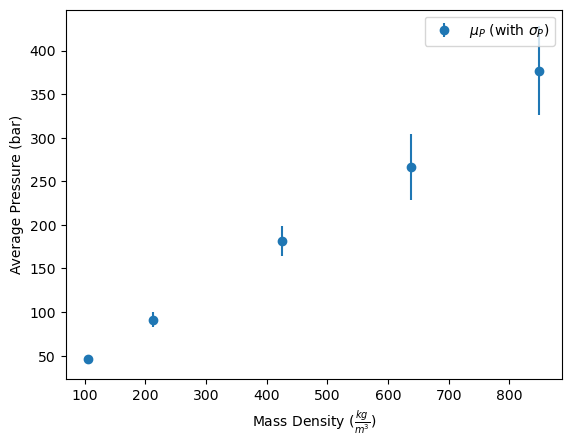

In [66]:
#store mass density per N
mass_density = np.zeros(5)

#values
molar_mass = 0.039948 #kg/mol
L = 2.5

for i in range(0, 5):
    moles = N_list[i]/6.02e23 #mol
    mass = molar_mass*moles #kg
    vol = (L*1e-9)**3 #nm^3 -> m^3
    mass_density[i] = mass/vol #kg/m^3

#plot as fxn of mass density
plt.errorbar(mass_density, uP_list_N, yerr=sig_list_N, fmt='o', label = r'$\mu_P$ (with $\sigma_P$)')
plt.xlabel(r'Mass Density ($\frac{kg}{m^{3}}$)')
plt.ylabel("Average Pressure (bar)")
plt.legend()
plt.show()

#### Equation of State

Plot of Pressure Calculations (Van der Waals vs Ideal Gas vs Simulation):

$P(\rho), P_{ideal}(\rho), P_{vdW}(\rho)$

For Ar: a = $0.1355\frac{Pam^{6}}{mol^{2}}$, b = $03.201 x 10^{-5}\frac{m^{3}}{mol}$

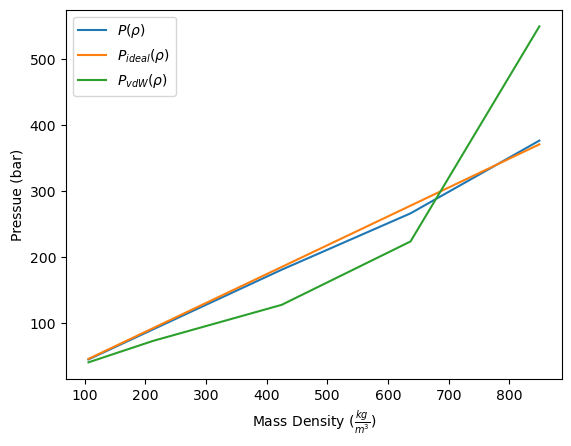

In [73]:
P_ideal_list = np.zeros(5)
P_VDW_list = np.zeros(5)

Av = 6.02e23 
a = 0.1355 #Pa*m^6/mol^2
b = 3.201e-5 #m^3/mol
R = 8.314 #m^3*Pa/(K*mol)
k = 1.38064852e-23 #J/K
L = 2.5e-9 #nm -> mm
V = L**3 #m^3
T = 210 #K

for i in range(0, 5):
    
    rho = N_list[i]/V #1/m^3
    
    P_ideal_list[i] = N_list[i]*k*T/V 
    P_ideal_list[i] *= 1e-5 #Pa -> bar

    rho /= Av #mol/m^3
    
    P_VDW_list[i] =  (R*T) / ( rho**(-1) - b) 
    P_VDW_list[i] -= (a*(rho)**2)
    P_VDW_list[i] *= 1e-5 #Pa -> bar
    

#plot eeach curve as fxn of mass density
plt.plot(mass_density, uP_list_N, label=r'$P(\rho)$')
plt.plot(mass_density, P_ideal_list, label=r'$P_{ideal}(\rho)$')
plt.plot(mass_density, P_VDW_list, label=r'$P_{vdW}(\rho)$')
plt.xlabel(r'Mass Density ($\frac{kg}{m^{3}}$)')
plt.ylabel(r'Pressue (bar)')
plt.legend()

The ideal gas estimation is completely linear (P = NRT/V) in relation to density because it does not account for any intermolecular forces (interactions) between the particles in the substance. The Van der Waals approximation accounts for these forces and provides a relationship that is no longer linear but varies with density depending on material-specific parameters "a" and "b". The particles can actually "see" each other in this system, and these forces are accounted for. Our simulation models Argon but treats each particle independently. Therefore, our pressure at each mass density is more similar to the idea gas approximation. 

### 15) NPT Ensemble

Perform one volume-change trial per N particle displacement trial moves such that one MC Sweep comprises N particle displacement trials and one volume-change trial

In [55]:
#Metropolis Monte-Carlo Loop for NVT/NPT Ensemble
def MCMC_2(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB, P_targ, flag):
    
    #NPT
    if(flag): 
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        outfile = './ArgonNPT_Pressure.xyz'
        xyzWrite(xyz, outfile, 'a')

        #pressure initializations
        P_tot = 0
        P_block_tot = 0
        P_block = np.zeros(5)
   
        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        L_list = np.zeros(nSweeps)
        Sweeps_list = np.zeros(nSweeps)
        
        #counts
        num_accept = 0
        num_trials = 0
        blocknum = 0
        
        #volume dispSize
        V_dispSize = 2

        #inital energy of the system
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            
            #perform regular displacement trial N times
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = np.copy(xyz[atom,:])

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                            num_accept += 1

                num_trials += 1
                    
            #now perform volume trial move
            
            #old volume
            V_old = L**3
            
            #calculate old energy
            E_old = E_system(xyz, L, sigma, epsilon)
            
            #new coordinates to edit
            xyz_new = np.copy(xyz)

            #random volume displacement
            dV = np.random.uniform(-V_dispSize,V_dispSize)

            #new volume 
            V_new = V_old + dV
            
            #new side length
            L_new = V_new**(1.0/3.0)

            #scale L_new/L_old
            scale = L_new/L
            
            #scale the particles to new positions
            xyz_new *= scale
            
            #calculate new energy
            E_new = E_system(xyz_new, L_new, sigma, epsilon)

            #calculate change in energy
            deltaE = E_new - E_old 

            if T>0:
                #acceptance condition for volume trial move
                log_chi =  -((deltaE + (P_targ / 10 * dV)) / (kB*T)) + (N * (np.log(V_new/V_old))) 
                if log_chi >= math.log(np.random.uniform(0,1)):
                    #update coordinates and side length
                    xyz = np.copy(xyz_new)
                    L = L_new
                    num_accept += 1       
            
            num_trials += 1
                
            #store values for plotting
            E_list[i] = E_system(xyz, L, sigma, epsilon)
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            L_list[i] = L
            Sweeps_list[i] = i+1

            #print every printModulus sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("Pressure: %.2f" % P_list[i])
                print("")

            #write every writeModulus sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')
            
        #plots
        fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True)
    
        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        ax3.plot(Sweeps_list, L_list, label='$Length_{(sweep)}$')
        ax3.set_ylabel('Side Length (nm)')
        ax3.legend()

        plt.xlabel('Sweep Number')
        plt.show()

    
    #NVT
    else:
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        
        outfile = './ArgonNVT_Pressure.xyz'
        xyzWrite(xyz, outfile, 'a')

        #initializations
        E = 0
        P_tot = 0
        P_block_tot = 0
        P_block = np.zeros(5)

        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        Sweeps_list = np.zeros(nSweeps)

        #counters
        num_accept = 0
        num_trials = 0
        blocknum = 0

        #inital system energy
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = xyz[atom,:]

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = xyz_atom_new_wrap
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = xyz_atom_new_wrap
                            E += deltaE
                            num_accept += 1

                num_trials += 1

            #add values to be able to plot
            E_list[i] = E
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            Sweeps_list[i] = i+1

            #print every printModulus Sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("")

            #write every writeModulus Sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')

        #plots
        fig, (ax1, ax2) = plt.subplots(2,sharex=True)

        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        plt.xlabel('Sweep Number')
        plt.show()

In [57]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))
P_targ = float(input("P (target):"))
flag = int(input("NPT = 1, NVT = 0:"))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 50
Number of MC Sweeps: 500
Characteristic Size of Atomic Displacement Trial Moves: 0.5
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.03806425
P (target):300
NPT = 1, NVT = 0:1


NPT Monte Carlo Simulation of Ar with N = 50, L(initial) = 2.5nm, T = 298K, P(target) = 300bar, nSweeps = 500

System Energy: -82.195
Acceptance Ratio: 0.647
Pressure: 114.36

System Energy: -344.095
Acceptance Ratio: 0.713
Pressure: 104.31

System Energy: -646.758
Acceptance Ratio: 0.700
Pressure: 100.78

System Energy: -918.697
Acceptance Ratio: 0.699
Pressure: 105.75

System Energy: -1203.222
Acceptance Ratio: 0.703
Pressure: 85.61

System Energy: -1497.204
Acceptance Ratio: 0.709
Pressure: 114.91

System Energy: -1741.128
Acceptance Ratio: 0.711
Pressure: 94.60

System Energy: -2062.604
Acceptance Ratio: 0.716
Pressure: 126.67

System Energy: -2458.422
Acceptance Ratio: 0.711
Pressure: 101.26

System Energy: -2715.348
Acceptance Ratio: 0.715
Pressure: 95.41

System Energy: -2994.355
Acceptance Ratio: 0.716
Pressure: 113.85

System Energy: -3304.514
Acceptance Ratio: 0.717
Pressure: 132.10

System Energy: -3591.007
Acceptance Ratio: 0.720
Pressure: 99.15

System Energy: -3821.952
Acceptance Ratio: 0.723
Pressure: 75.97

System Energy: -4121.064
Acceptance Ratio: 0.725
Pressure: 89.98

System

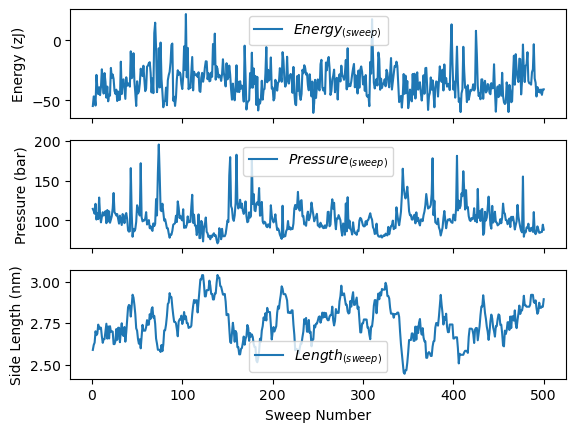

In [56]:
MCMC_2(298, 2.5, 50, 500, 0.5, 10, 10, 0.34, 1.65, 0.03806425, 300, 1)

### 16) Radial Distribution Function

In [65]:
def g_r(r_max, dr, xyz, L, nSteps, rho, nFrames):
    
    gr = np.zeros(nSteps)
    r_list = np.linspace(0.01, r_max, nSteps)
    
    for frame in range(0, nFrames):
        
        step = 0
    
        xyz = xyz_list[:,:,frame]
        
        for i in range(len(r_list)):

            count = 0

            r = r_list[i]

            N = xyz.shape[0]

            for atom in range(0,N): 

                particle = xyz[atom,:] 

                for j in range(0, N):

                    if (j!=atom) :

                        d = dist(particle,xyz[j,:],L)

                        if (d >= r and d <= (r + dr)):
                            count+=1

            count = count/4/np.pi/(r**2)/dr/N
            gr[step] += count
            step+=1 

    gr /= rho
    gr /= nFrames
    
    return gr

In [72]:
#Metropolis Monte-Carlo Loop for NVT/NPT Ensemble with g(r)
def MCMC_3(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB, P_targ, flag):
    
    #NPT
    if(flag): 
        
        #target pressure
        P_targ = P_targ #bar-->zJ/nm**3
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        outfile = './ArgonNPT.xyz'
        xyzWrite(xyz, outfile, 'a')

        #initializations
        E = 0
        P_tot = 0
        P_block_tot = 0
        P_block = np.zeros(5)
   
        #counts
        num_accept = 0
        num_trials = 0
        blocknum = 0
        nFrames = 0
        
        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        L_list = np.zeros(nSweeps)
        xyz_list = np.zeros((N,3,300))
        Sweeps_list = np.zeros(nSweeps)
        
        #starting volume dispSize
        V_dispSize = 0.5

        #inital energy of the system
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            
            #perform regular displacement trial N times
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = np.copy(xyz[atom,:])

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                            E += deltaE
                            num_accept += 1

                num_trials += 1
                    
            #now perform volume trial move
            
            #old volume
            V_old = L**3
            
            #new coordinates to edit
            xyz_new = np.copy(xyz)
    
            #calculate old energy
            E_old = E_system(xyz, L, sigma, epsilon)
            
            #random volume displacement
            dV = np.random.uniform(-V_dispSize,V_dispSize)

            #new volume
            V_new = V_old + dV
            
            #new side length
            L_new = V_new**(1.0/3.0)

            #scale L_new/L_old
            scale = L_new/L
            
            #scale the particles to new positions
            xyz_new *= scale
            
            #calculate new energy
            E_new = E_system(xyz_new, L_new, sigma, epsilon)

            #calculate change in energy
            deltaE = E_new - E_old 

            if T>0 and abs(E) < 1000:
                #acceptance condition for volume trial move
                log_chi =  -((deltaE + (P_targ / 10 * dV)) / (kB*T)) + (N * (np.log(V_new/V_old))) 
                if log_chi >= math.log(np.random.uniform(0,1)):
                    #update coordinates and side length
                    xyz = np.copy(xyz_new)
                    L = L_new
                    num_accept += 1
                    
            num_trials += 1

            #store values for plotting
            E_list[i] = E
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            L_list[i] = L
            Sweeps_list[i] = i+1

            #print every printModulus sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("Pressure: %.2f " % P_list[i])
                print("")
    
            #write every writeModulus sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')
              
            #after an equilibration period, append xyz for g(r) calculation
            if(i >= 200):
                xyz_list[:,:,nFrames] = xyz
                nFrames += 1
    
        #plots
        fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True)
    
        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        ax3.plot(Sweeps_list, L_list, label='$Length_{(sweep)}$')
        ax3.set_ylabel('Side Length (nm)')
        ax3.legend()

        plt.xlabel('Sweep Number')
        plt.show()
        
        return xyz_list, nFrames
    
    #NVT
    else:
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        
        outfile = './ArgonNVT.xyz'
        xyzWrite(xyz, outfile, 'a')

        #initializations
        E = 0
        P_tot = 0
        P_block_tot = 0
        P_block = np.zeros(5)

        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        Sweeps_list = np.zeros(nSweeps)

        #counters
        num_accept = 0
        num_trials = 0
        blocknum = 0

        #initial system energy
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = xyz[atom,:]

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = xyz_atom_new_wrap
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = xyz_atom_new_wrap
                            E += deltaE
                            num_accept += 1

                num_trials += 1

            #add values to be able to plot
            E_list[i] = E
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            Sweeps_list[i] = i+1

            #print every printModulus Sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("")

            #write every writeModulus Sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')

        #plots
        fig, (ax1, ax2) = plt.subplots(2,sharex=True)

        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        plt.xlabel('Sweep Number')
        plt.show()


1. $P_{targ}$ = 50, T = 298 K:

System Energy: -65.989
Acceptance Ratio: 0.667
Pressure: 162.72 

System Energy: -44.903
Acceptance Ratio: 0.638
Pressure: 114.62 

System Energy: -32.587
Acceptance Ratio: 0.663
Pressure: 105.61 

System Energy: -22.914
Acceptance Ratio: 0.676
Pressure: 99.10 

System Energy: 2.158
Acceptance Ratio: 0.697
Pressure: 93.55 

System Energy: -11.221
Acceptance Ratio: 0.707
Pressure: 87.78 

System Energy: 13.289
Acceptance Ratio: 0.711
Pressure: 82.18 

System Energy: -8.592
Acceptance Ratio: 0.716
Pressure: 89.90 

System Energy: 22.726
Acceptance Ratio: 0.717
Pressure: 88.81 

System Energy: -16.733
Acceptance Ratio: 0.720
Pressure: 89.05 

System Energy: -10.747
Acceptance Ratio: 0.719
Pressure: 82.92 

System Energy: -0.935
Acceptance Ratio: 0.724
Pressure: 80.00 

System Energy: -2.229
Acceptance Ratio: 0.728
Pressure: 76.91 

System Energy: 6.949
Acceptance Ratio: 0.734
Pressure: 75.42 

System Energy: 11.530
Acceptance Ratio: 0.736
Pressure: 76.69 

System Energy: -5.083
Acceptance

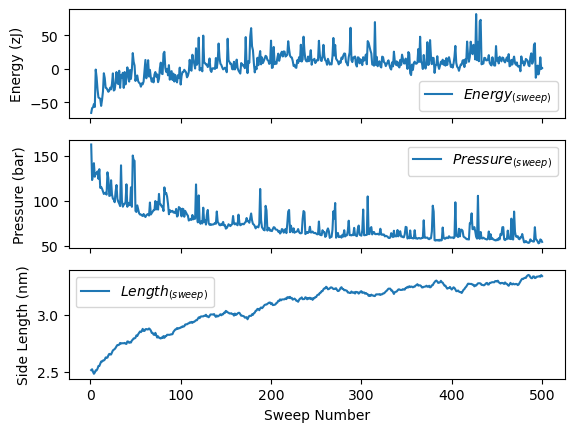

In [60]:
#Target Pressure = 50 bar, T = 298 K
xyz_list, nFrames = MCMC_3(298, 2.5, 50, 500, 0.5, 10, 10, 0.34, 1.65, 0.03806425, 50, 1)

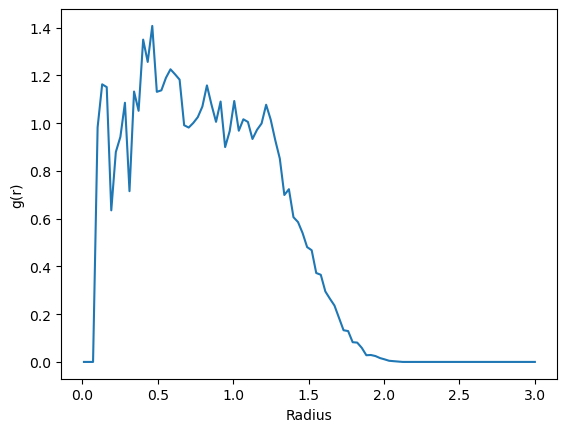

In [69]:
rho = N/L**3
r_max = 3
dr = 0.001
nSteps = 100
r_range = np.linspace(0.01, r_max, nSteps)

gr = g_r(3, 0.001, xyz_list, L, 100, rho, nFrames)
plt.plot(r_range, gr, label='g(r)')
plt.xlabel("Radius")
plt.ylabel("g(r)")
plt.show()

2. $P_{targ}$ = 100, T = 85 K:

System Energy: -63.835
Acceptance Ratio: 0.529
Pressure: 32.46 

System Energy: -72.661
Acceptance Ratio: 0.529
Pressure: 35.38 

System Energy: -63.099
Acceptance Ratio: 0.538
Pressure: 41.90 

System Energy: -70.138
Acceptance Ratio: 0.532
Pressure: 39.49 

System Energy: -55.770
Acceptance Ratio: 0.529
Pressure: 33.89 

System Energy: -83.222
Acceptance Ratio: 0.526
Pressure: 57.23 

System Energy: -75.869
Acceptance Ratio: 0.517
Pressure: 37.43 

System Energy: -87.176
Acceptance Ratio: 0.509
Pressure: 38.53 

System Energy: -86.144
Acceptance Ratio: 0.504
Pressure: 36.00 

System Energy: -74.419
Acceptance Ratio: 0.497
Pressure: 38.14 

System Energy: -87.343
Acceptance Ratio: 0.495
Pressure: 37.09 

System Energy: -90.029
Acceptance Ratio: 0.494
Pressure: 40.27 

System Energy: -79.157
Acceptance Ratio: 0.491
Pressure: 32.70 

System Energy: -93.453
Acceptance Ratio: 0.490
Pressure: 36.97 

System Energy: -93.856
Acceptance Ratio: 0.491
Pressure: 33.37 

System Energy: -109.064
A

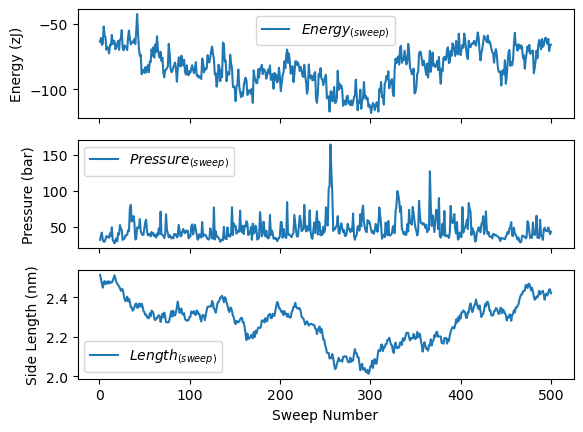

In [70]:
#Target Pressure = 100 bar, T = 85 K
xyz_list, nFrames = MCMC_3(85, 2.5, 50, 500, 0.4, 10, 10, 0.34, 1.65, 0.03806425, 100, 1)

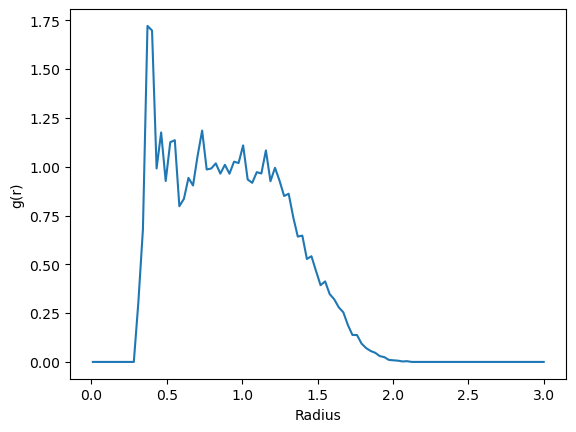

In [71]:
rho = N/L**3
r_max = 3
dr = 0.001
nSteps = 100
r_range = np.linspace(0.01, r_max, nSteps)

gr = g_r(3, 0.001, xyz_list, L, 100, rho, nFrames)
plt.plot(r_range, gr, label='g(r)')
plt.xlabel("Radius")
plt.ylabel("g(r)")
plt.show()

The difference between the radial distribution functions is mostly that the first peak seems to shrink with increasing temperature. The reasoning for this could be due to the different densities of the simulations. At a lower temperature, Argon behaves more like a liquid, so the probability of finding the particles within a smaller range is much higher versus when it behaves more like a gas. Gas particles are more likely to spread apart from each other (exhibiting lower density), and thus the radial distribution of finding particles spreads more evenly across various radii, with decreased likelihood of being in smaller distance ranges of each other. (Obviously my radial distribution graphs are wonky due to my system not reaching equilibrium/target pressure, so it is difficult to discern exactly how these curves would differ).